In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
from skater.core.global_interpretation.tree_surrogate import TreeSurrogate
#from skater.util.dataops import show_in_notebook ##??

import warnings
warnings.simplefilter("ignore")

In [2]:
featureNames = ["seq", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "loc"]
yeastData = pd.read_csv("yeast.data", sep=" ", names=featureNames)
kFold = KFold(n_splits=2, shuffle=False)
yeastAttrib = yeastData.iloc[:,1:9].values  # fix column indexes
yeastTarget = yeastData["loc"].values

titles = ("GradientBoost", "KNN", "Gaussian", "Random Forest", "MLP") # add more
models = (GradientBoostingClassifier(n_estimators=100, max_features=None, max_depth=2, random_state=5),
            KNeighborsClassifier(),
            GaussianNB(),
            RandomForestClassifier(),
            MLPClassifier())
dummy = DummyClassifier()

------------Fold 1
GradientBoost
             precision    recall  f1-score   support

        CYT       0.45      0.61      0.52       198
        ERL       0.00      0.00      0.00         5
        EXC       0.43      0.32      0.36        19
        ME1       0.52      0.65      0.58        17
        ME2       0.48      0.39      0.43        33
        ME3       0.72      0.89      0.80        74
        MIT       0.82      0.42      0.55       180
        NUC       0.50      0.53      0.52       197
        POX       0.55      0.43      0.48        14
        VAC       0.00      0.00      0.00         5

avg / total       0.58      0.54      0.54       742

Confusion Matrix: 
 [[121   0   0   0   1   6   7  62   0   1]
 [  0   0   2   0   2   0   0   0   0   1]
 [  5   0   6   3   3   0   0   1   0   1]
 [  0   0   2  11   2   1   0   0   1   0]
 [  2   0   2   5  13   3   1   3   2   2]
 [  0   0   0   0   0  66   0   8   0   0]
 [ 61   0   2   2   2   8  75  27   2   1]
 [ 74  

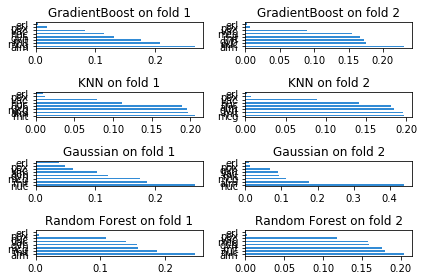

In [3]:
fold = 1
fig, axs = plt.subplots(len(models), kFold.n_splits)
for train_index, test_index in kFold.split(yeastAttrib):
    print(f"------------"
          f"Fold {fold}")
    modelno = 1
    train_data, train_target = yeastAttrib[train_index], yeastTarget[train_index]
    test_data, test_target = yeastAttrib[test_index], yeastTarget[test_index]
    dummy.fit(train_data, train_target)
    prediction = dummy.predict(test_data)
    print("Dummy prediction")
    print(classification_report(test_target, prediction))
    for model, title in zip(models, titles):
        clf = model.fit(train_data, train_target)
        prediction = clf.predict(test_data)
        print(f"{title}")
        print(classification_report(test_target, prediction))
        print(f"Confusion Matrix: \n {confusion_matrix(test_target, prediction)}")

        ax = axs[modelno - 1, fold - 1]
        interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
        # model_no_proba = InMemoryModel(model.predict, examples=test_data, unique_values=model.classes_)
        model_mem = InMemoryModel(model.predict_proba, examples=test_data)
        interpreter.feature_importance.plot_feature_importance(model_mem, ascending=False, ax=ax, progressbar=False)
        ax.set_title(f"{title} on fold {fold}")
        print("\n")
        modelno += 1
    fold += 1
plt.rcParams["figure.figsize"] = (30,30)
plt.tight_layout()

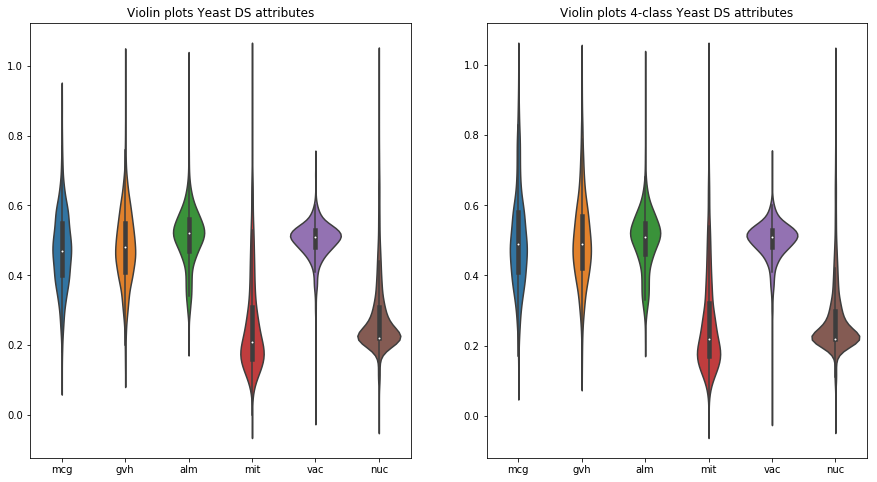

In [4]:
yeast4Classes = yeastData.loc[(yeastData["loc"] == "CYT")|( yeastData["loc"] == "NUC" )| (yeastData["loc"] == "MIT" )| (yeastData["loc"] == "ME3")]
yeastAttrib = yeast4Classes.iloc[:, 1:9].values  # fix column indexes
yeastTarget = yeast4Classes["loc"].values
plt.rcParams["figure.figsize"] = (15,8)
plt.subplot(1,2,1)
plt.title("Violin plots Yeast DS attributes")
ax = sns.violinplot(data=yeast4Classes.iloc[:, [1, 2, 3, 4, 7, 8]], orient="v")
plt.subplot(1, 2, 2)
plt.title("Violin plots 4-class Yeast DS attributes")
ax = sns.violinplot(data=yeastData.iloc[:, [1, 2, 3, 4, 7, 8]], orient="v")

------------Fold 1
GradientBoost
             precision    recall  f1-score   support

        CYT       0.48      0.62      0.54       198
        ME3       0.70      0.88      0.78        75
        MIT       0.84      0.46      0.59       180
        NUC       0.52      0.54      0.53       197

avg / total       0.62      0.58      0.58       650

Confusion Matrix: 
 [[122   6   7  63]
 [  0  66   1   8]
 [ 58  13  82  27]
 [ 74   9   8 106]]


KNN
             precision    recall  f1-score   support

        CYT       0.42      0.67      0.52       198
        ME3       0.73      0.77      0.75        75
        MIT       0.81      0.42      0.55       180
        NUC       0.55      0.46      0.50       197

avg / total       0.60      0.55      0.55       650

Confusion Matrix: 
 [[132   5   9  52]
 [  9  58   2   6]
 [ 77  10  76  17]
 [ 94   6   7  90]]


Gaussian
             precision    recall  f1-score   support

        CYT       0.39      0.58      0.47       198
       

TypeError: __init__() got an unexpected keyword argument 'feature_names'

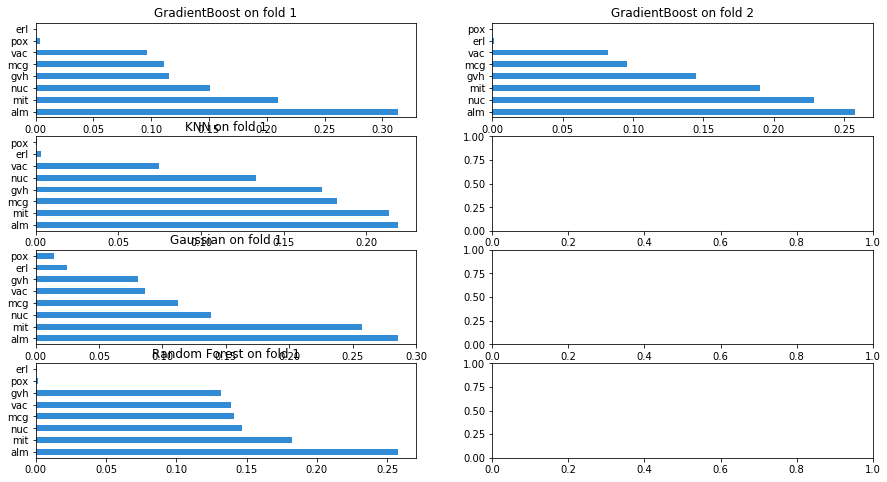

In [12]:
fold = 1
fig, axs = plt.subplots(len(models), kFold.n_splits)
for train_index, test_index in kFold.split(yeastAttrib):
    print(f"------------"
          f"Fold {fold}")
    modelno = 1
    train_data, train_target = yeastAttrib[train_index], yeastTarget[train_index]
    test_data, test_target = yeastAttrib[test_index], yeastTarget[test_index]
    prediction = dummy.predict(test_data)
    print("Dummy prediction")
    print(classification_report(test_target, prediction))
    for model, title in zip(models, titles):
        clf = model.fit(train_data, train_target)
        prediction = clf.predict(test_data)
        print(f"{title}")
        print(classification_report(test_target, prediction))
        print(f"Confusion Matrix: \n {confusion_matrix(test_target, prediction)}")

        ax = axs[modelno - 1, fold - 1]
        interpreter = Interpretation(test_data, feature_names=featureNames[1:9])
        # model_no_proba = InMemoryModel(model.predict, examples=test_data, unique_values=model.classes_)
        pyint_model = InMemoryModel(model.predict_proba, examples=test_data,
                                    target_names=["CYT", "ME3", "MIT", "NUC"])
        interpreter.feature_importance.plot_feature_importance(pyint_model, ascending=False, ax=ax,
                                                               progressbar=False)
        ax.set_title(f"{title} on fold {fold}")
        print("\n")
        
        ## To avoid clutter I only produce plots for gradient boosting and one fold only
        if (fold==2 and modelno==1):
            # Plot PDPs of variable "alm" since it is the most important feature, for 3 of the 4 models 
                ## Not for Gaussian Naive bayes tho, explain that
            # for other variables just change the name
            # for other models just change the number
#             interpreter.partial_dependence.plot_partial_dependence(["alm"], pyint_model, grid_resolution=30, with_variance=True)
            # PDP interaction between two variables, for each class
#             interpreter.partial_dependence.plot_partial_dependence([("nuc", "mit")], pyint_model, grid_resolution=10)
#             surrogate_explainer = interpreter.tree_surrogate(feature_names= featureNames[1:9], 
#                                            class_names=["CYT", "ME3", "MIT", "NUC"], seed=5)
#             y_hat_train = model.predict(train_data)
#             y_hat = models['gb'].predict(test_data)

            
            print(f"""Surrogate score: 
                      {surrogate_explainer.learn(train_data, y_hat_train, oracle_y=train_target, cv=True)}""")

            surrogate_explainer.plot_global_decisions(colors=['coral', 'darkkhaki'],
                                                      file_name='simple_tree_class.png', fig_size=(8, 8))
        # couldnt figure how to put it into one subplot, since it plots directly
        modelno += 1
    fold += 1
plt.rcParams["figure.figsize"] = (30,30)
plt.tight_layout()

In [6]:
# Add surrogate (¿our own or Skater's?)

In [7]:
#Remove observations, do the same